<a href="https://colab.research.google.com/github/toussaintma/neuralnetworksfromzerotohero/blob/main/walkthrough_makemore_activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# data and code at https://github.com/karpathy/makemore
# course at https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2&t=11s
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# Building makemore Part 3: Activations & Gradients, BatchNorm
# BatchNorm paper

--2023-07-16 15:47:47--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2023-07-16 15:47:47 (13.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df_words = pd.read_csv('names.txt', header=None, names=['name'])
words = df_words['name'].values.tolist()
df_words.shape

(32033, 1)

In [7]:
chars = sorted(list(set("".join(words))))
stoi = {c : i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i + 1: chars[i] for i in range(len(chars))}
itos[0] = '.'

In [8]:
block_size = 5
emb_size = 15
inner_size = 300

In [9]:
def build_dataset(word):
  X = []
  Y = []
  for w in words[:]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), ' --> ', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [102]:
C = torch.randn((27, emb_size))
W1 = torch.randn((block_size * emb_size, inner_size)) * (5/3)/((block_size * emb_size)**0.5)
#b1 = torch.randn(inner_size) * 0.01
W2 = torch.randn((inner_size, 27)) * 0.01
b2 = torch.randn(27) * 0

bngain = torch.ones((1, inner_size))
bnbias = torch.zeros((1, inner_size))
bnmean_running = torch.zeros((1, inner_size))
bnstd_running = torch.ones((1, inner_size))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters)

31632

In [103]:
lossi = []
max_steps = 20000
batch_size = 64

step:      0/  20000 loss:3.2832
step:   1000/  20000 loss:2.3414
step:   2000/  20000 loss:2.4329
step:   3000/  20000 loss:2.1085
step:   4000/  20000 loss:2.5837
step:   5000/  20000 loss:2.0441
step:   6000/  20000 loss:2.2964
step:   7000/  20000 loss:2.4483
step:   8000/  20000 loss:2.1874
step:   9000/  20000 loss:2.1672
step:  10000/  20000 loss:1.9684
step:  11000/  20000 loss:2.4285
step:  12000/  20000 loss:2.1233
step:  13000/  20000 loss:2.3197
step:  14000/  20000 loss:2.0840
step:  15000/  20000 loss:2.1839
step:  16000/  20000 loss:2.2848
step:  17000/  20000 loss:2.0099
step:  18000/  20000 loss:2.0160
step:  19000/  20000 loss:2.1702
2.0329949855804443


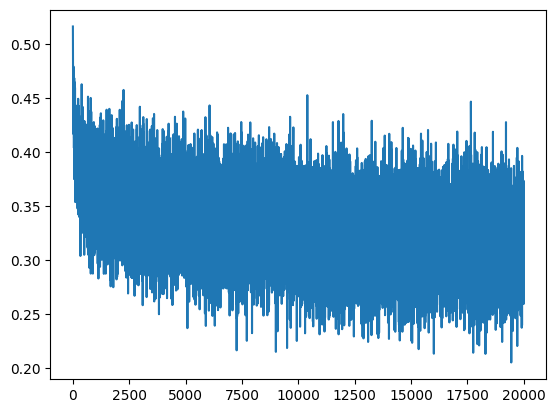

In [104]:
for i in range(max_steps):
  # mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))

  # forward pass
  emb = C[Xtr[ix]]
  embcat = emb.view(emb.shape[0], -1) #block_size * emb_size
  # Linear layer
  preact = embcat @ W1 #+ b1 not needed because of batch norm
  # Batch Norm layer
  bnmeani = preact.mean(dim=0, keepdim=True)
  bnstdi = preact.std(dim=0, keepdim=True)
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  preact = bngain * (preact - bnmeani) / bnstdi + bnbias
  # Non-linearity
  h = torch.tanh(preact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  if i < 10000:
    lr = 0.1
  else:
    lr = 0.01

  for p in parameters:
    p.data -= lr * p.grad

  # stats
  if (i % 1000 == 0):
    print(F'step:{i:7d}/{max_steps:7d} loss:{loss.item():.4f}')
  lossi.append(loss.log10().item())
  #plt.hist(h.view(-1).tolist(), 50)
  #plt.figure(figsize=(20, 10))
  #plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

  #break

print(loss.item())
plt.plot(lossi)

In [86]:
#calibrate the batch norm
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  preact = embcat @ W1 #+ b1
  bnmean = preact.mean(dim=0, keepdim=True)
  bnstd = preact.std(dim=0, keepdim=True)

In [95]:
#(bnmean - bnmean_running).abs() > 0.1

In [105]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  #preact = emb.view(emb.shape[0], -1) @ W1 + b1
  embcat = emb.view(emb.shape[0], -1)
  preact = embcat @ W1 #+ b1 not needed due to batch norm
  #preact = bngain * (preact - preact.mean(dim=0, keepdim=True)) / preact.std(dim=0, keepdim=True) + bnbias
  preact = bngain * (preact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(preact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0734364986419678
dev 2.0734364986419678


In [106]:
def sample():
  output = []
  context = [0] * block_size
  sample = 0

  while True:
    emb = C[torch.tensor(context)] # 1, 3, 10
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1).item()
    context = context[1:] + [ix]
    output.append(ix)
    if ix == 0:
      break
  return output

In [107]:
for j in range(2):
  print(''.join([itos[i] for i in sample()]))

karjjwnsttgrenslofraystrabstah.
magderlosghnfvekglaj.


In [36]:
-torch.tensor(1/27.0).log()

tensor(3.2958)